# **NVIDIA Stock Price Analysis**
## **Objective:**
- The primary objective of this project is to further my understanding of NVIDIA as a company and a stock market investment. This can be done using the following:
- Use Deep Learning & Neural Networks (application of research).
- Perform an EDA on NVIDIA's stock price, and relate this to the real world. This could involve:
    - Trend Analysis
    - Volatility Analysis
    - Earnings Reports
    - Balance Sheet Health
    - Sector Trends
    - Competitive Position
    - Sentiment of Other Investors
- Perform a predictive analysis on NVIDIA's stock price.
    - Using RNNs and LSTMs
- Perform the analysis above with reference to NVIDIA's competitors
    - Namely, AMD, Intel and QualComm
    

### Installations:

In [26]:
%pip install pandas
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports:

In [27]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

In [28]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

### Data Retreival & Cleaning:

In [29]:
# Retrieve 5 Years of NVIDIA's Stock Data
stocks = ['NVDA', 'AMD', 'INTC', 'QCOM']
data_list = []

# now = datetime.now()
now = datetime(2023, 11, 1)


for stock in stocks:
    df = yf.download(stock, now - relativedelta(years=5), now)
    df['Stock'] = stock
    data_list.append(df)

c_names = ["NVIDIA", "AMD", "INTEL", "QUALCOMM"]
colors = {
    "NVIDIA": "green",
    "INTEL": "#6fa8dc", 
    "AMD": "red",
    "QUALCOMM": "darkblue" 
}

for c_data, c_name in zip(data_list, c_names):
    c_data['Company Name'] = c_name

data = pd.concat(data_list, axis = 0)

# Descriptive Statistics & Information
print(data.describe())
print(data.info())

# Data Cleaning

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
              Open         High          Low        Close    Adj Close  \
count  5028.000000  5028.000000  5028.000000  5028.000000  5028.000000   
mean     99.566320   101.290330    97.805996    99.587025    97.028310   
std      75.823577    77.207539    74.294991    75.781616    76.084572   
min      16.520000    17.219999    16.030001    16.650000    16.650000   
25%      49.820000    50.537499    49.114999    49.829376    45.980624   
50%      79.029999    80.270000    77.783749    78.834999    76.791351   
75%     129.184994   130.799995   126.642500   128.857506   125.067814   
max     502.160004   502.660004   489.579987   493.549988   493.465942   

             Volume  
count  5.028000e+03  
mean   3.9398

### EDA of Stock Price

#### Data Visualisation

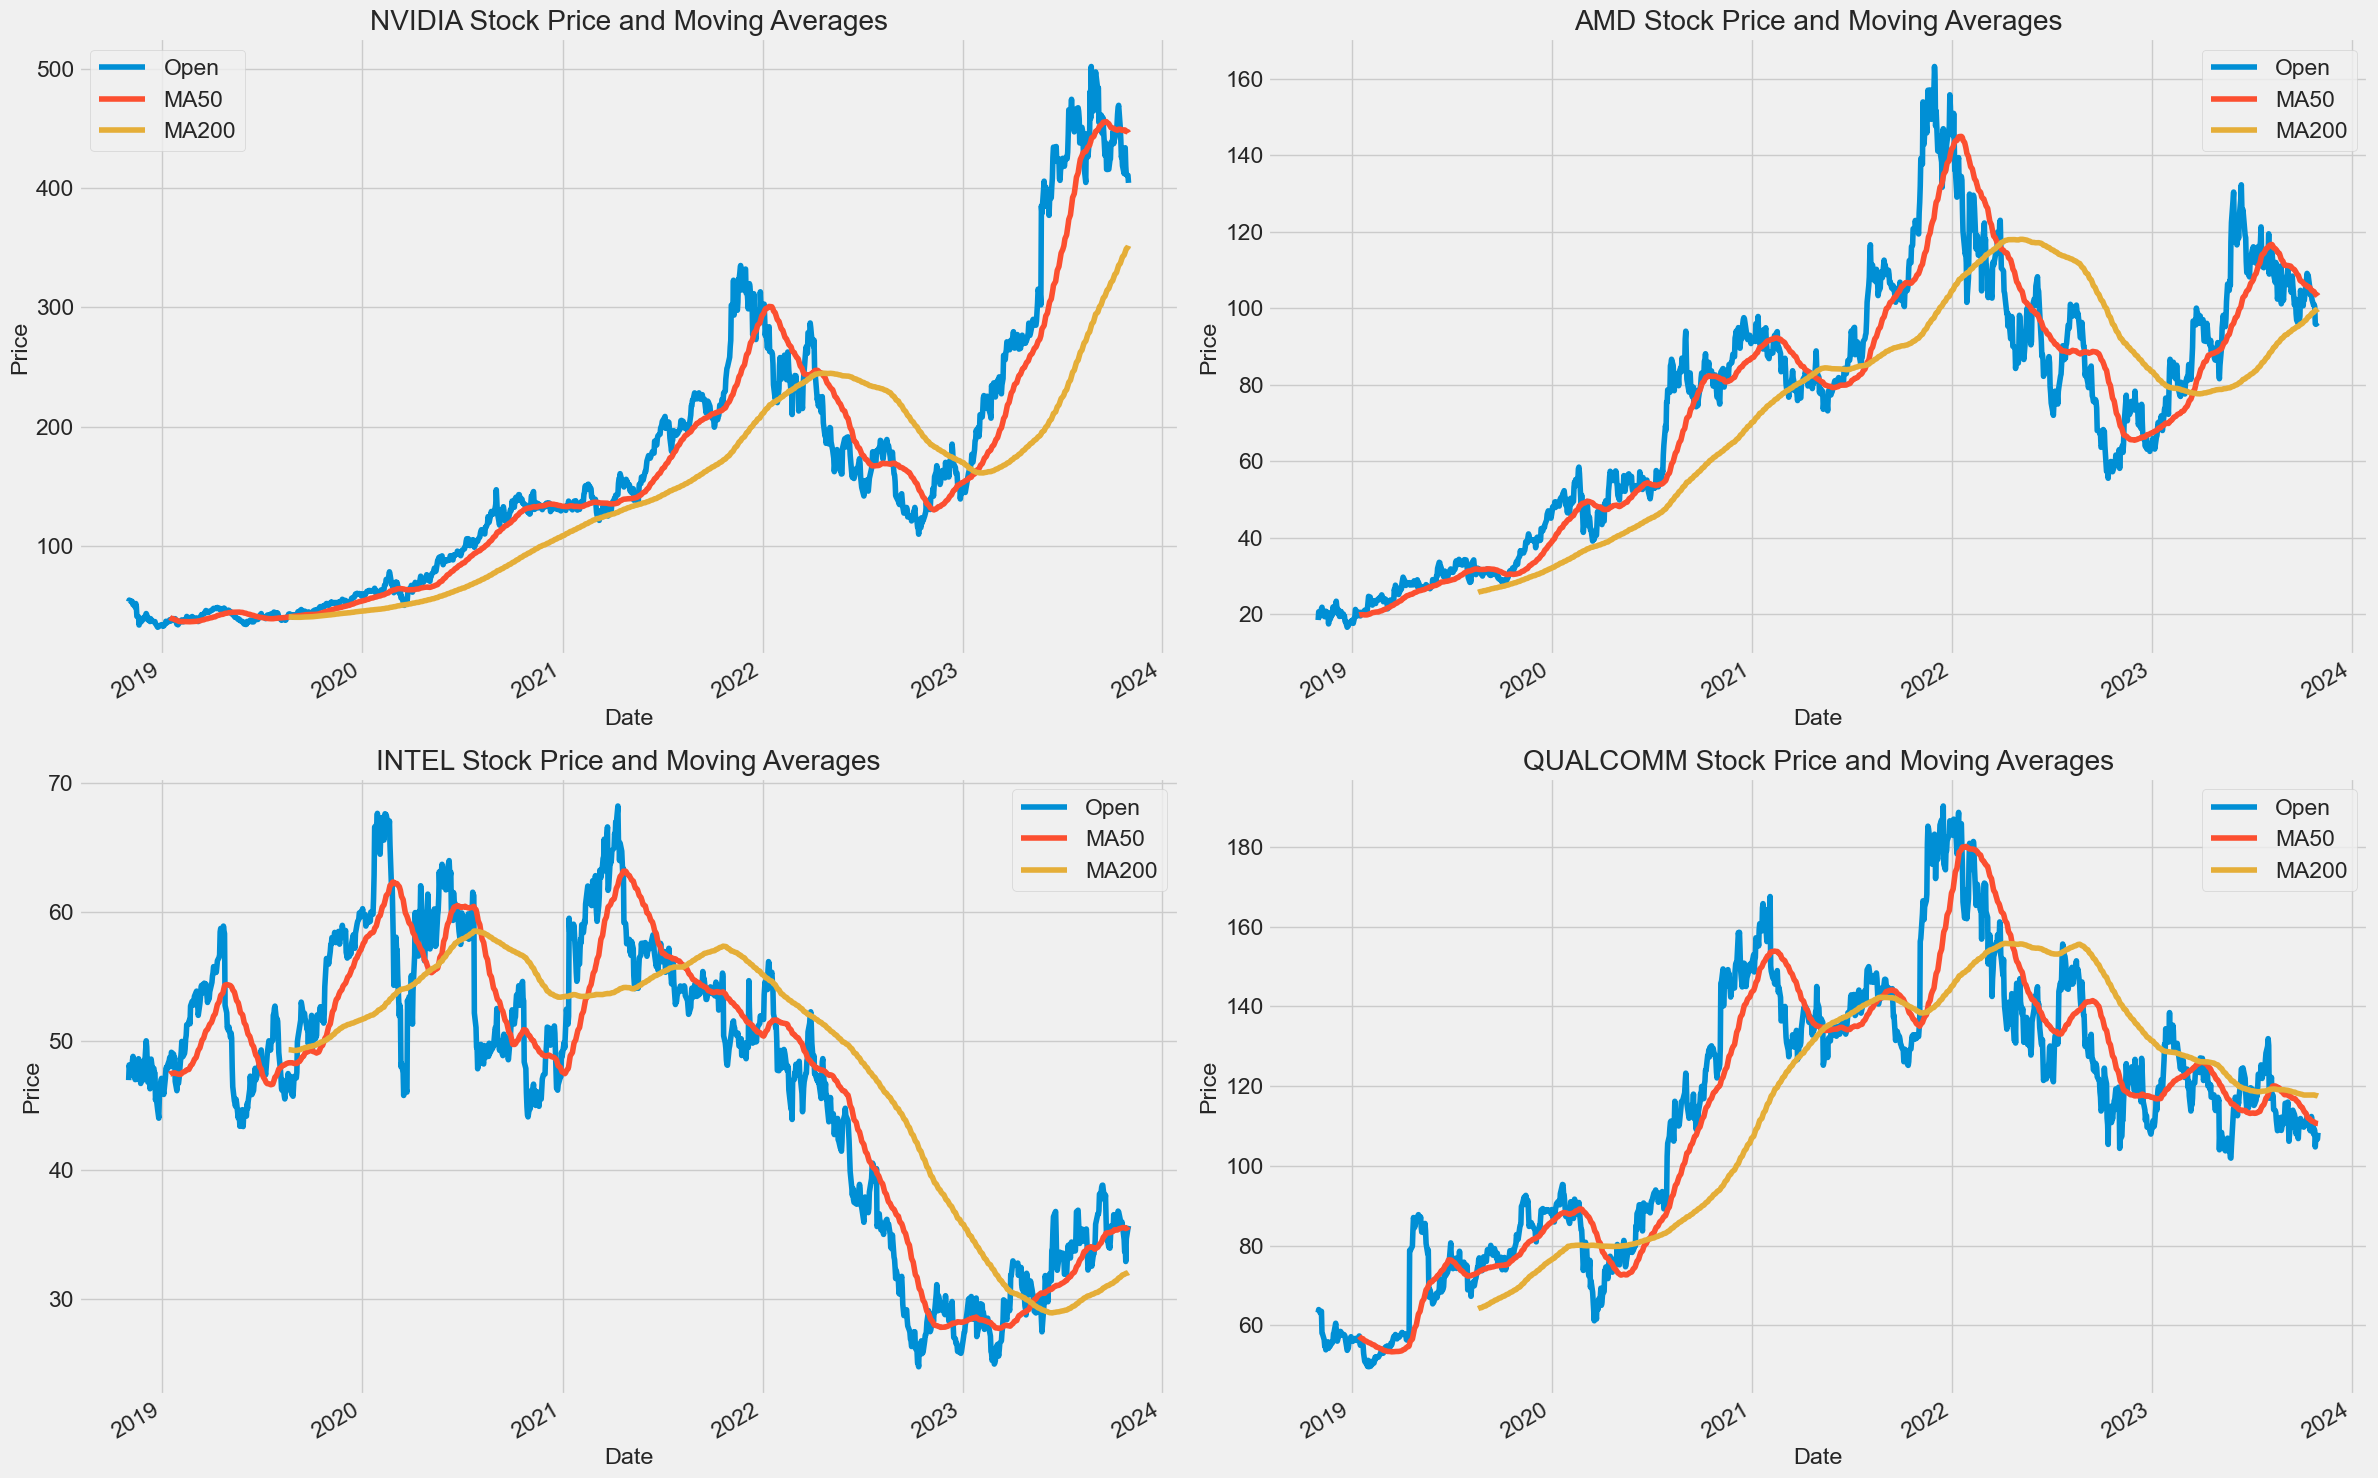

In [30]:
# Set up the matplotlib figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

for i, (c_data, c_name) in enumerate(zip(data_list, c_names)):
    c_data['MA50'] = c_data['Open'].rolling(50).mean()
    c_data['MA200'] = c_data['Open'].rolling(200).mean()
    
    # Direct Pandas plot to use a specific Matplotlib subplot
    c_data[['Open', 'MA50', 'MA200']].plot(ax=axs[i], figsize=(24, 15), title=f"{c_name} Stock Price and Moving Averages")
    
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend(["Open", "MA50", "MA200"])

plt.tight_layout()
plt.show()

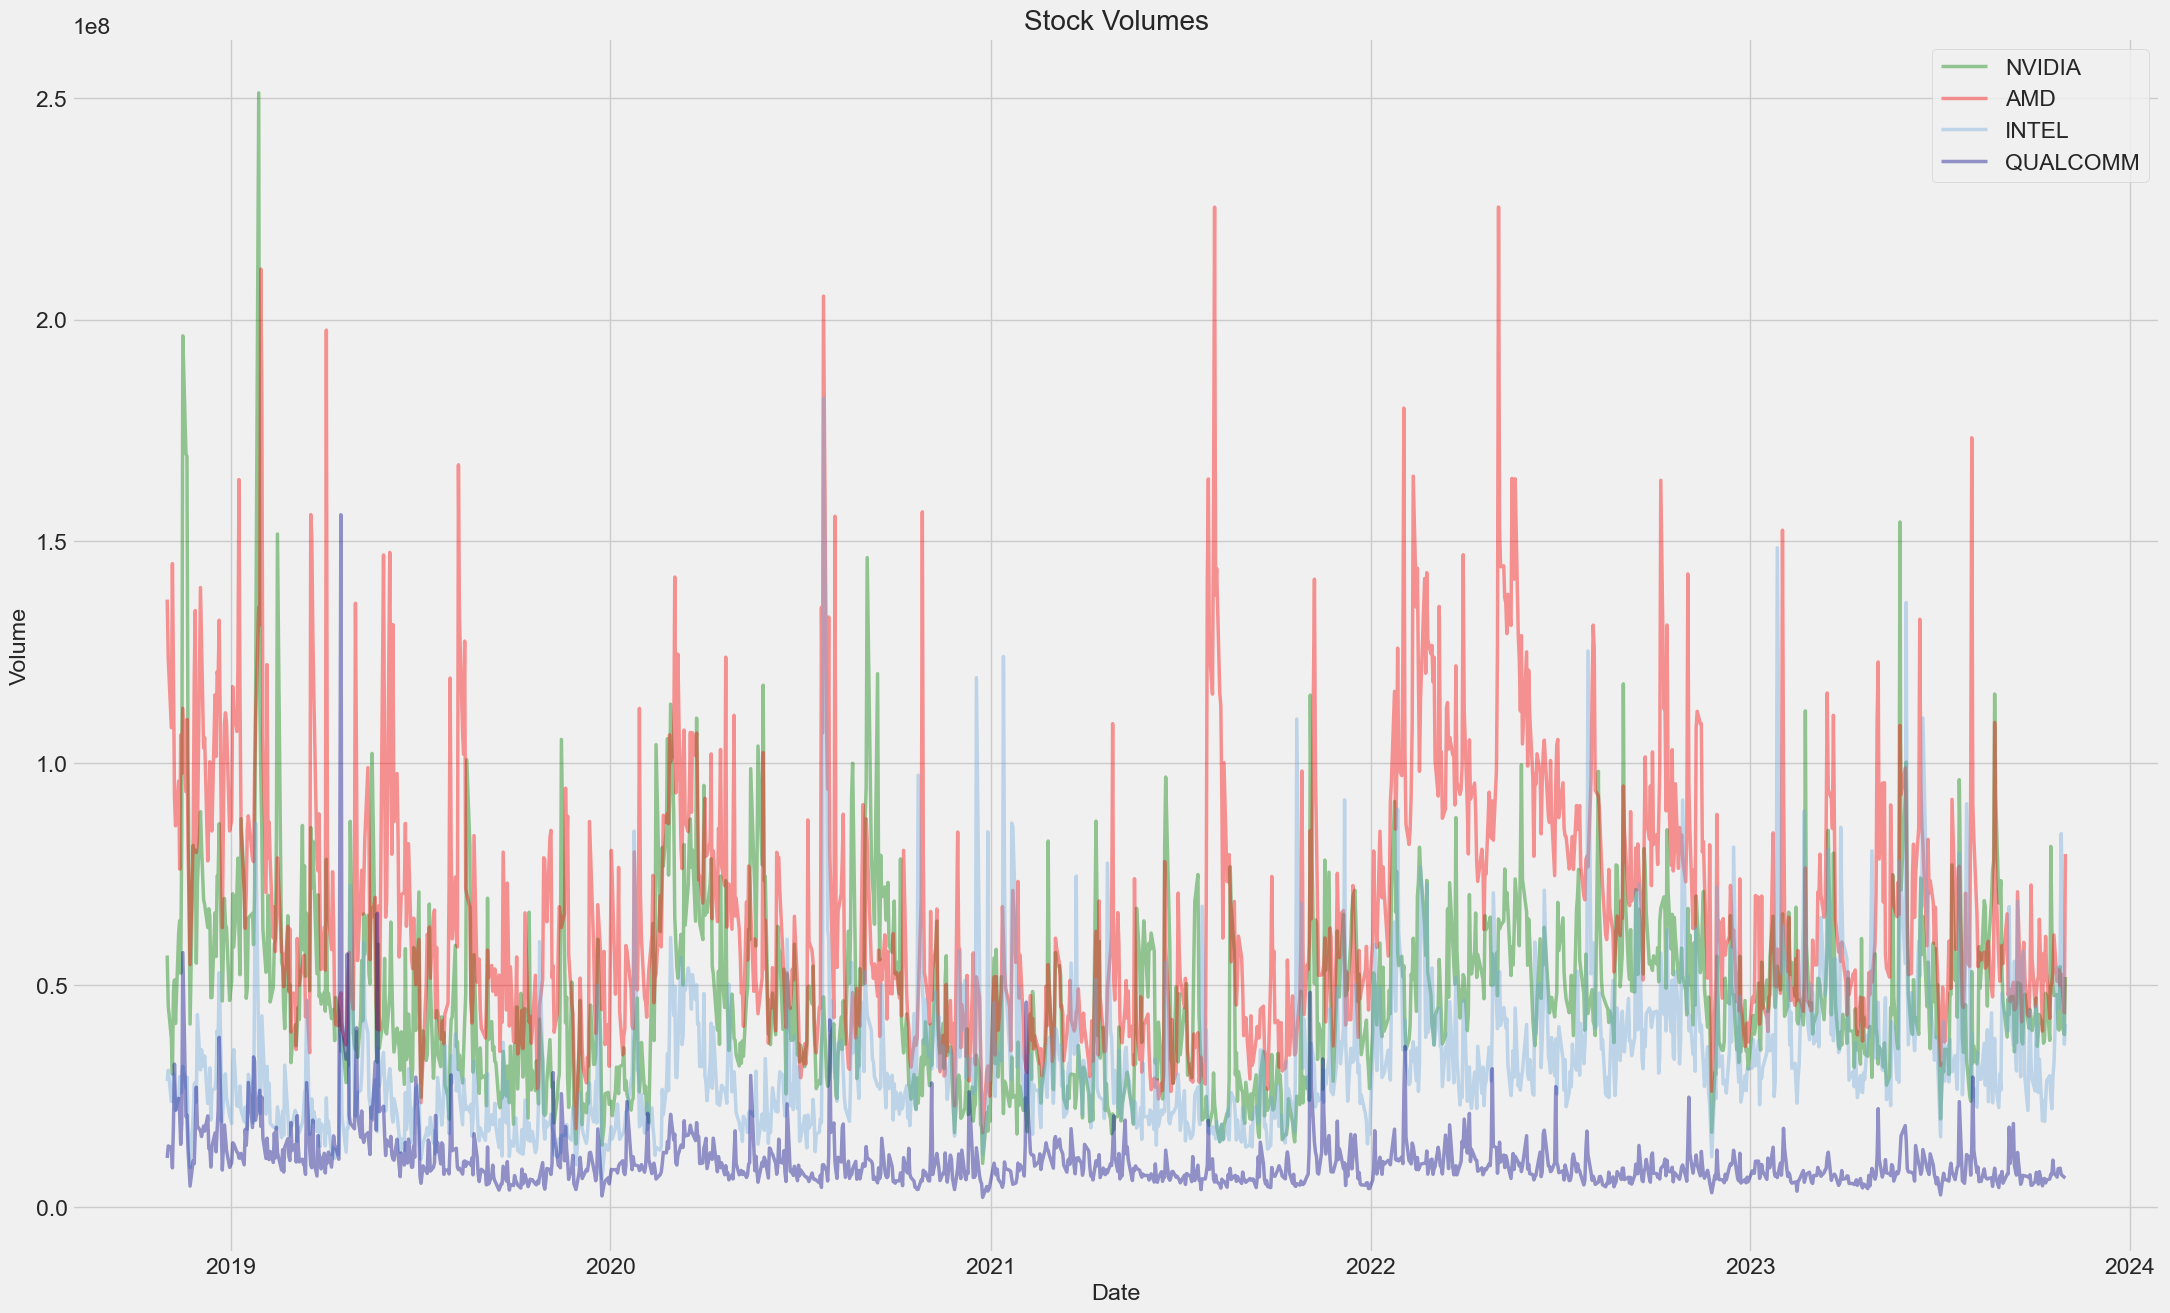

In [31]:
# Set the figure size and title
plt.figure(figsize=(24, 15))
plt.title("Stock Volumes")

# Filter and plot volume for each company
for c_name in c_names:
    # Filter the data for the current company
    company_data = data[data['Company Name'] == c_name]
    
    # Plot the volume data
    plt.plot(company_data.index, company_data['Volume'], label=c_name, color=colors[c_name], alpha=0.4, linewidth=2.5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

#### Annual Growth Rate

In [32]:
# Calculating Compound Annual Growth Rate
cagr_results = {}
n_years = 5  # The period over which we're calculating CAGR

for c_data, c_name in zip(data_list, c_names):
    # Extract the closing price at the beginning and end of the period
    beginning_value = c_data['Adj Close'].iloc[0]
    ending_value = c_data['Adj Close'].iloc[-1]
    
    # Calculate CAGR
    cagr = ((ending_value / beginning_value) ** (1 / n_years)) - 1
    cagr_results[c_name] = cagr

# Print the CAGR for each company
for company, cagr in cagr_results.items():
    print(f"{company}: {cagr*100:.2f}% annual growth rate")

NVIDIA: 49.80% annual growth rate
AMD: 37.26% annual growth rate
INTEL: -2.74% annual growth rate
QUALCOMM: 14.32% annual growth rate


#### Correlation

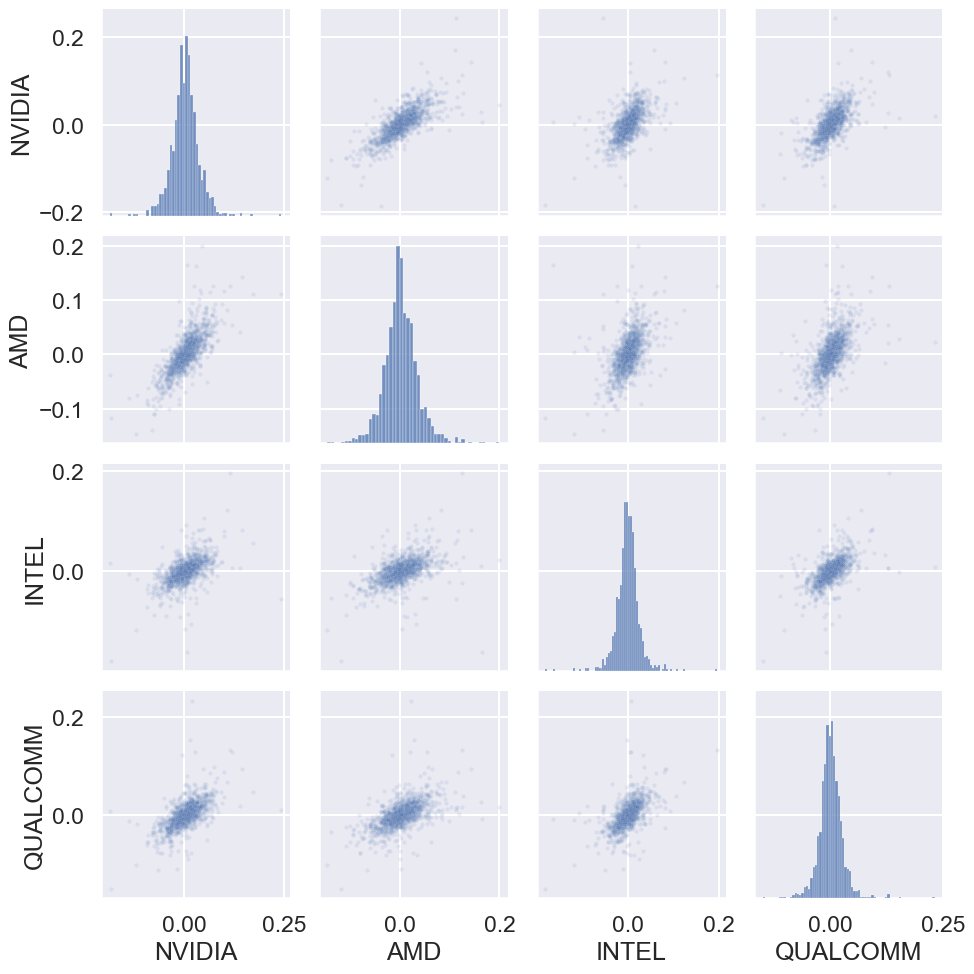

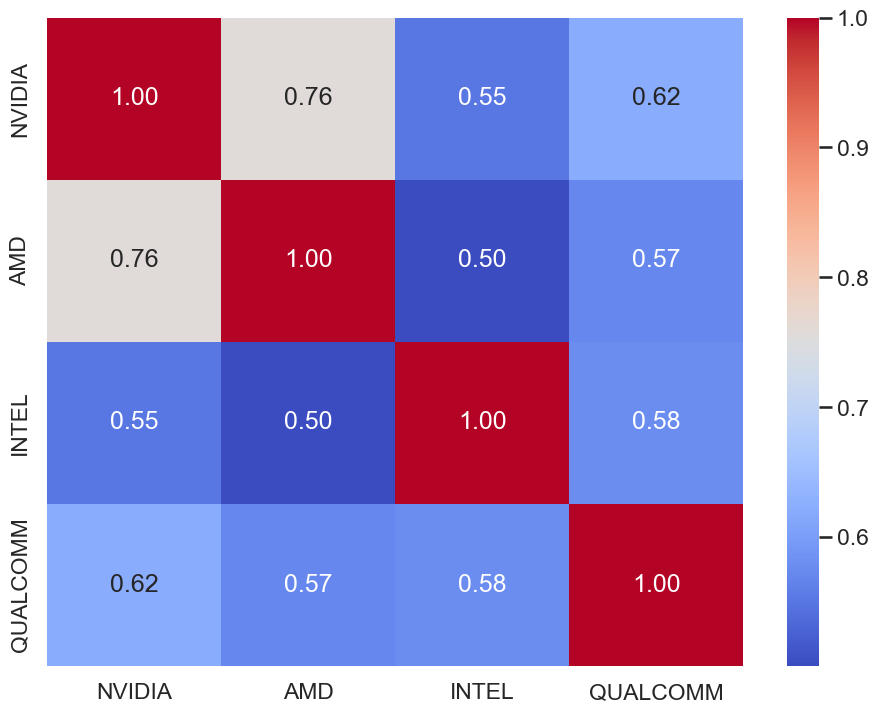

In [33]:
# Select only the 'Adj Close' column for each stock
adj_closes = pd.DataFrame({c_name: c_data['Adj Close'] for c_data, c_name in zip(data_list, c_names)})

# Correlation as PairPlot
tech_rets = adj_closes.pct_change()
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('talk')
sns.pairplot(tech_rets, kind='scatter', plot_kws={'alpha':0.1, 's':10})
sns.set_palette('deep')
sns.set_style('whitegrid', {'axes.grid' : True})

plt.show()

# Correlation as Heatmap
corr_matrix = tech_rets.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### Risk VS Expected Return

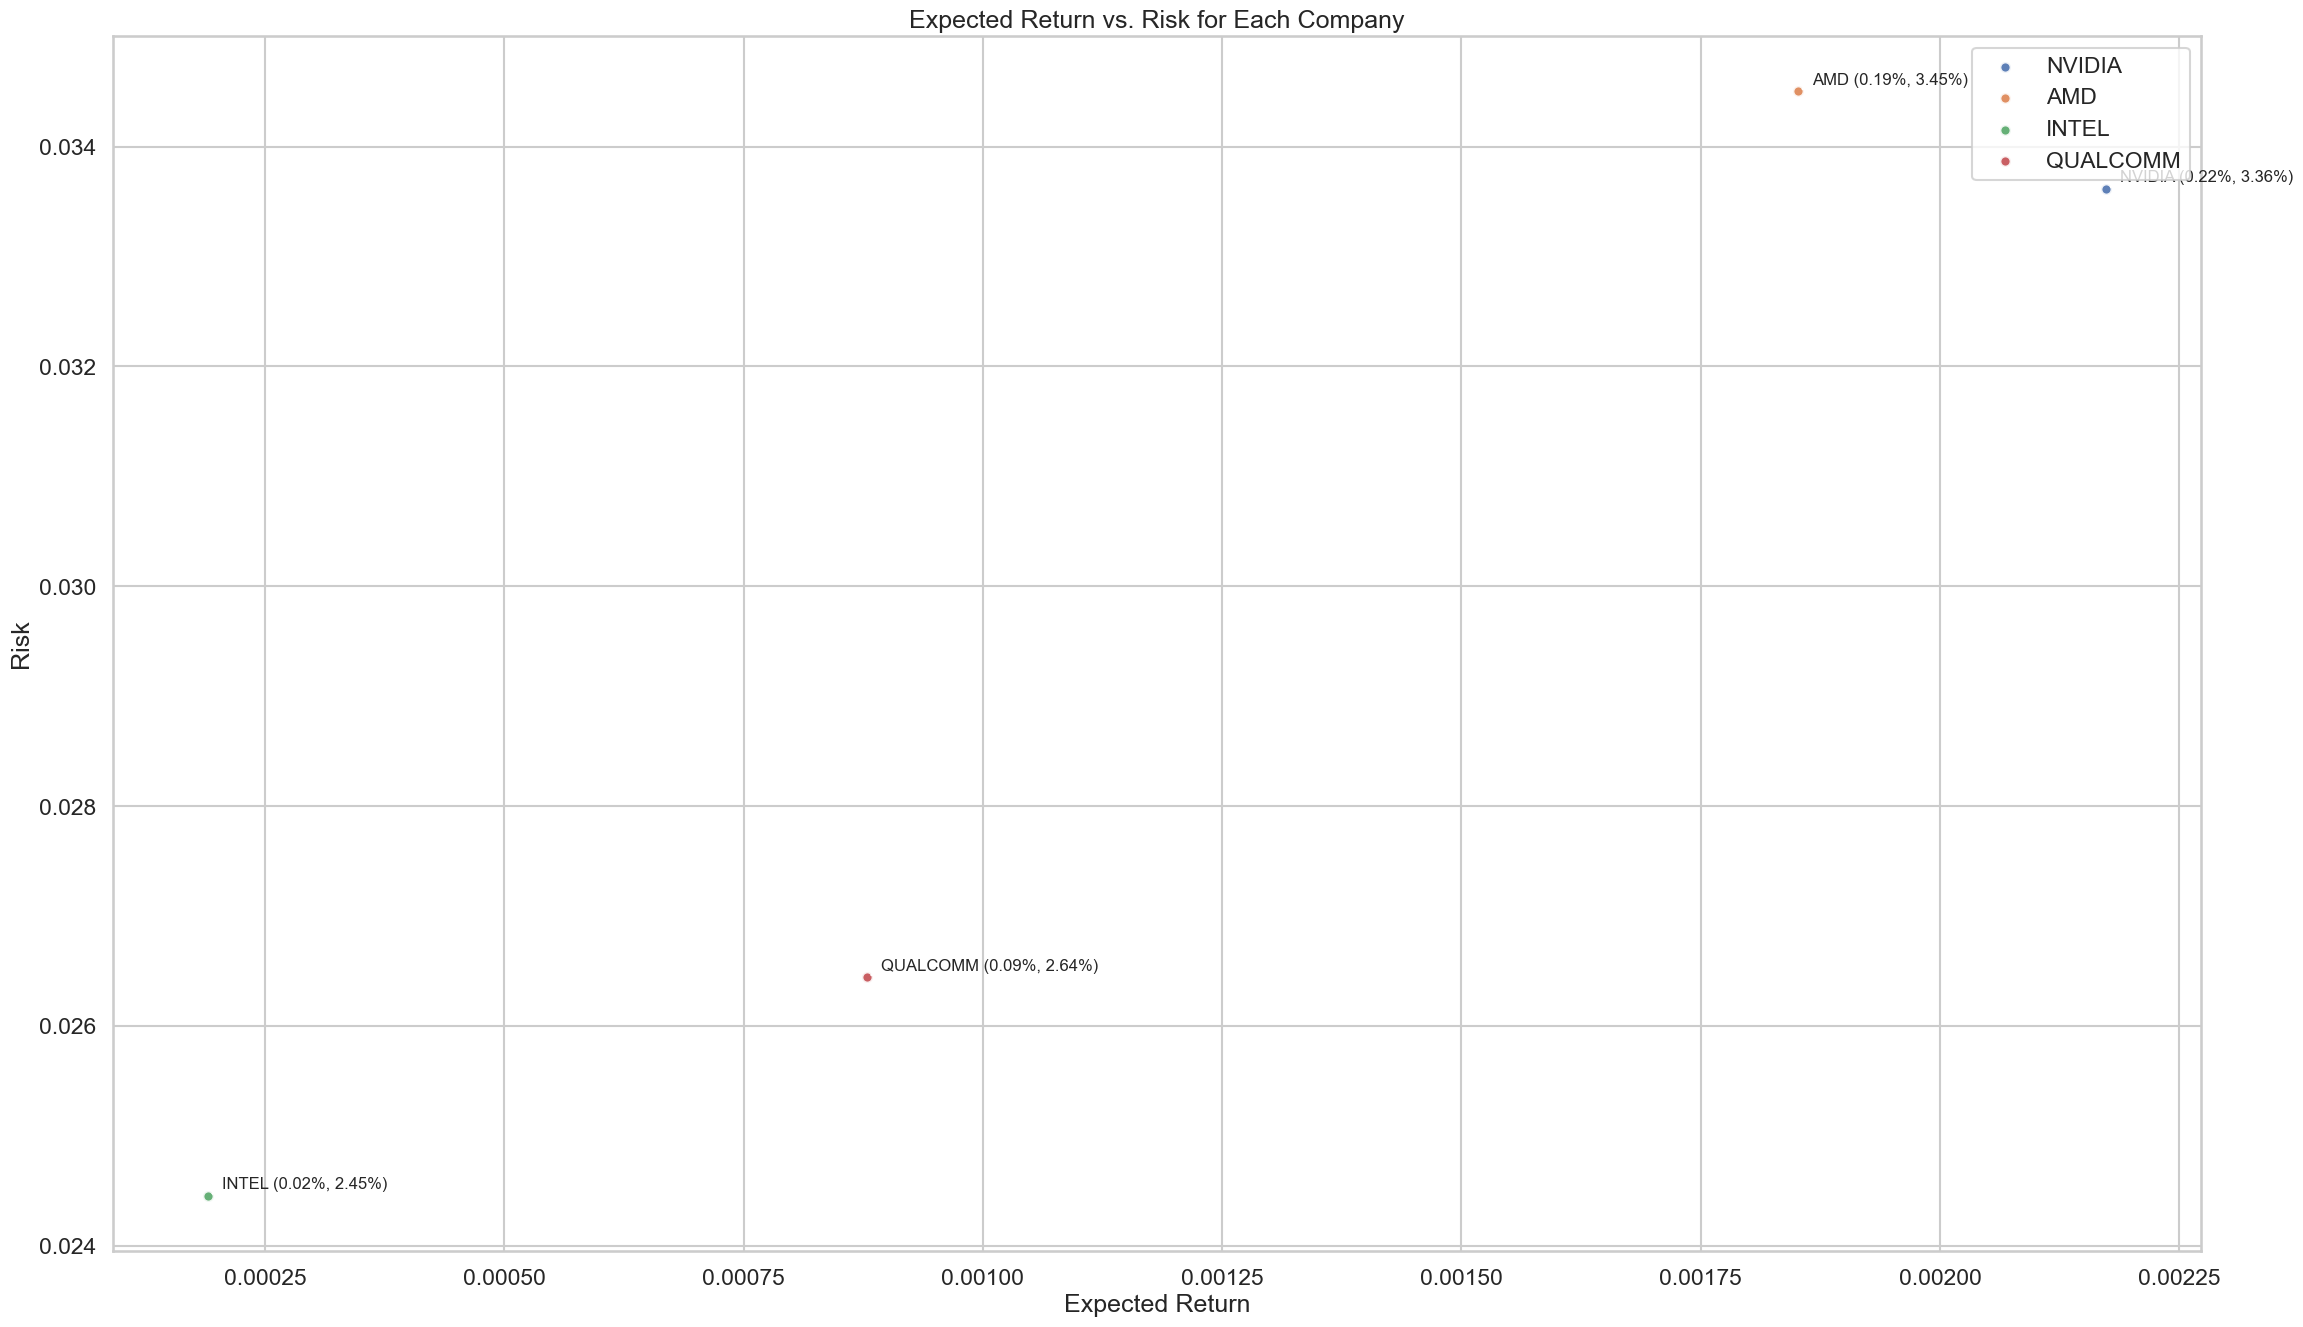

In [34]:
plt.figure(figsize=(24, 15))
area = np.pi * 20

# Iterate over each company name to calculate and plot their expected return and risk
for c_name in c_names:
    # Create a boolean mask for the current company
    mask = data['Company Name'] == c_name
    # Calculate the daily return and store it in a temporary variable instead of modifying the slice directly
    daily_return = data.loc[mask, 'Adj Close'].pct_change()
    # Now you can work with daily_return directly without modifying the original DataFrame
    mean_return = daily_return.mean()
    risk = daily_return.std()
    
    plt.scatter(mean_return, risk, s=area, label=c_name, alpha=0.9, linewidths=2, edgecolors='w')
    
    plt.annotate(f'{c_name} ({mean_return:.2%}, {risk:.2%})', 
        xy=(mean_return, risk), 
        xytext=(10, 5), 
        textcoords='offset points', 
        fontsize=12, 
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.title('Expected Return vs. Risk for Each Company')
plt.xlabel('Expected Return')
plt.ylabel('Risk')

plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Target Distribution

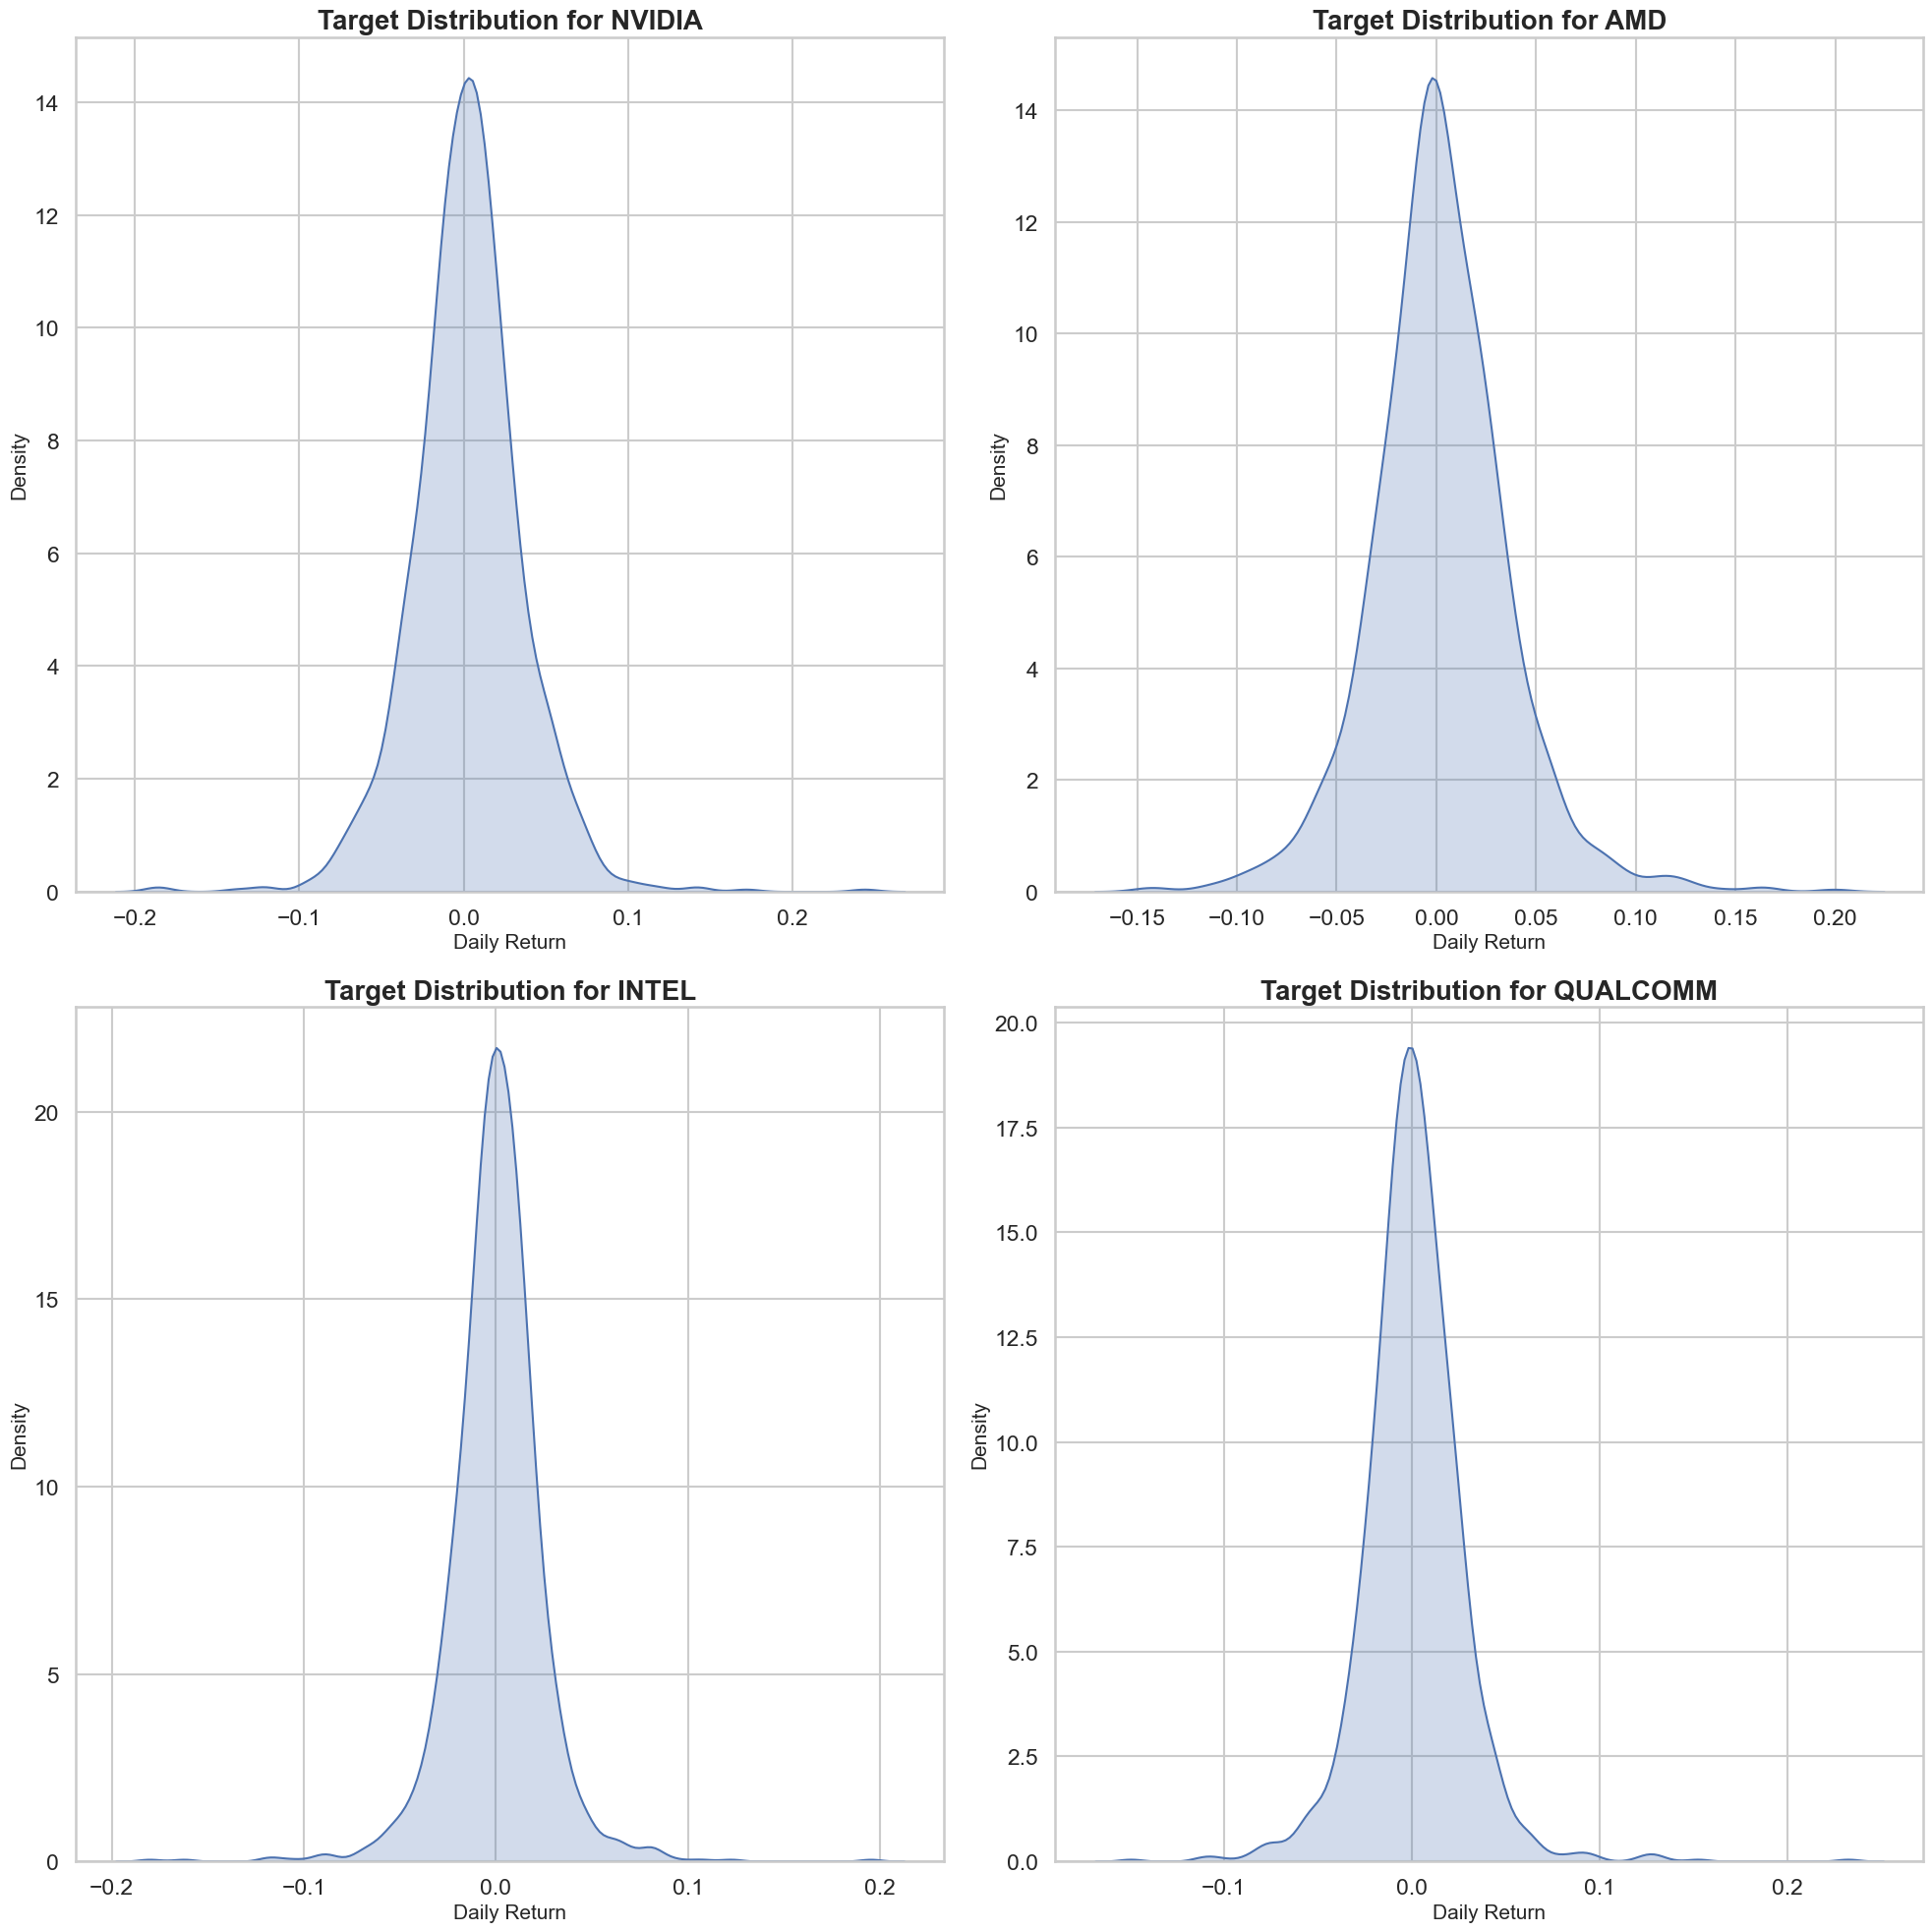

In [35]:
# Create a new figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Loop through each stock in your list and plot its target distribution
for i, (stock_data, stock_name) in enumerate(zip(data_list, c_names)):
    # Calculate the target variable (e.g., daily returns) for the current stock
    daily_return = stock_data['Adj Close'].pct_change()
    
    # Plot the target distribution using a KDE plot on the appropriate subplot
    row, col = divmod(i, 2)  # Calculate the row and column indices of the subplot
    sns.kdeplot(daily_return.dropna(), fill=True, ax=axs[row, col])
    axs[row, col].set_title(f'Target Distribution for {stock_name}', weight='bold', fontsize=20)
    axs[row, col].set_xlabel('Daily Return', fontsize=15)
    axs[row, col].set_ylabel('Density', fontsize=15)

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
mean_target = daily_return.mean()
median_target = daily_return.median()
std_target = daily_return.std()
skewness_target = daily_return.skew()
kurtosis_target = daily_return.kurtosis()

print(f"Mean: {mean_target}")
print(f"Median: {median_target}")
print(f"Standard Deviation: {std_target}")
print(f"Skewness: {skewness_target}")
print(f"Kurtosis: {kurtosis_target}")

Mean: 0.0008787760719566188
Median: 0.00036219253559621745
Standard Deviation: 0.02644488285624813
Skewness: 0.7023495602309566
Kurtosis: 8.477756148296239


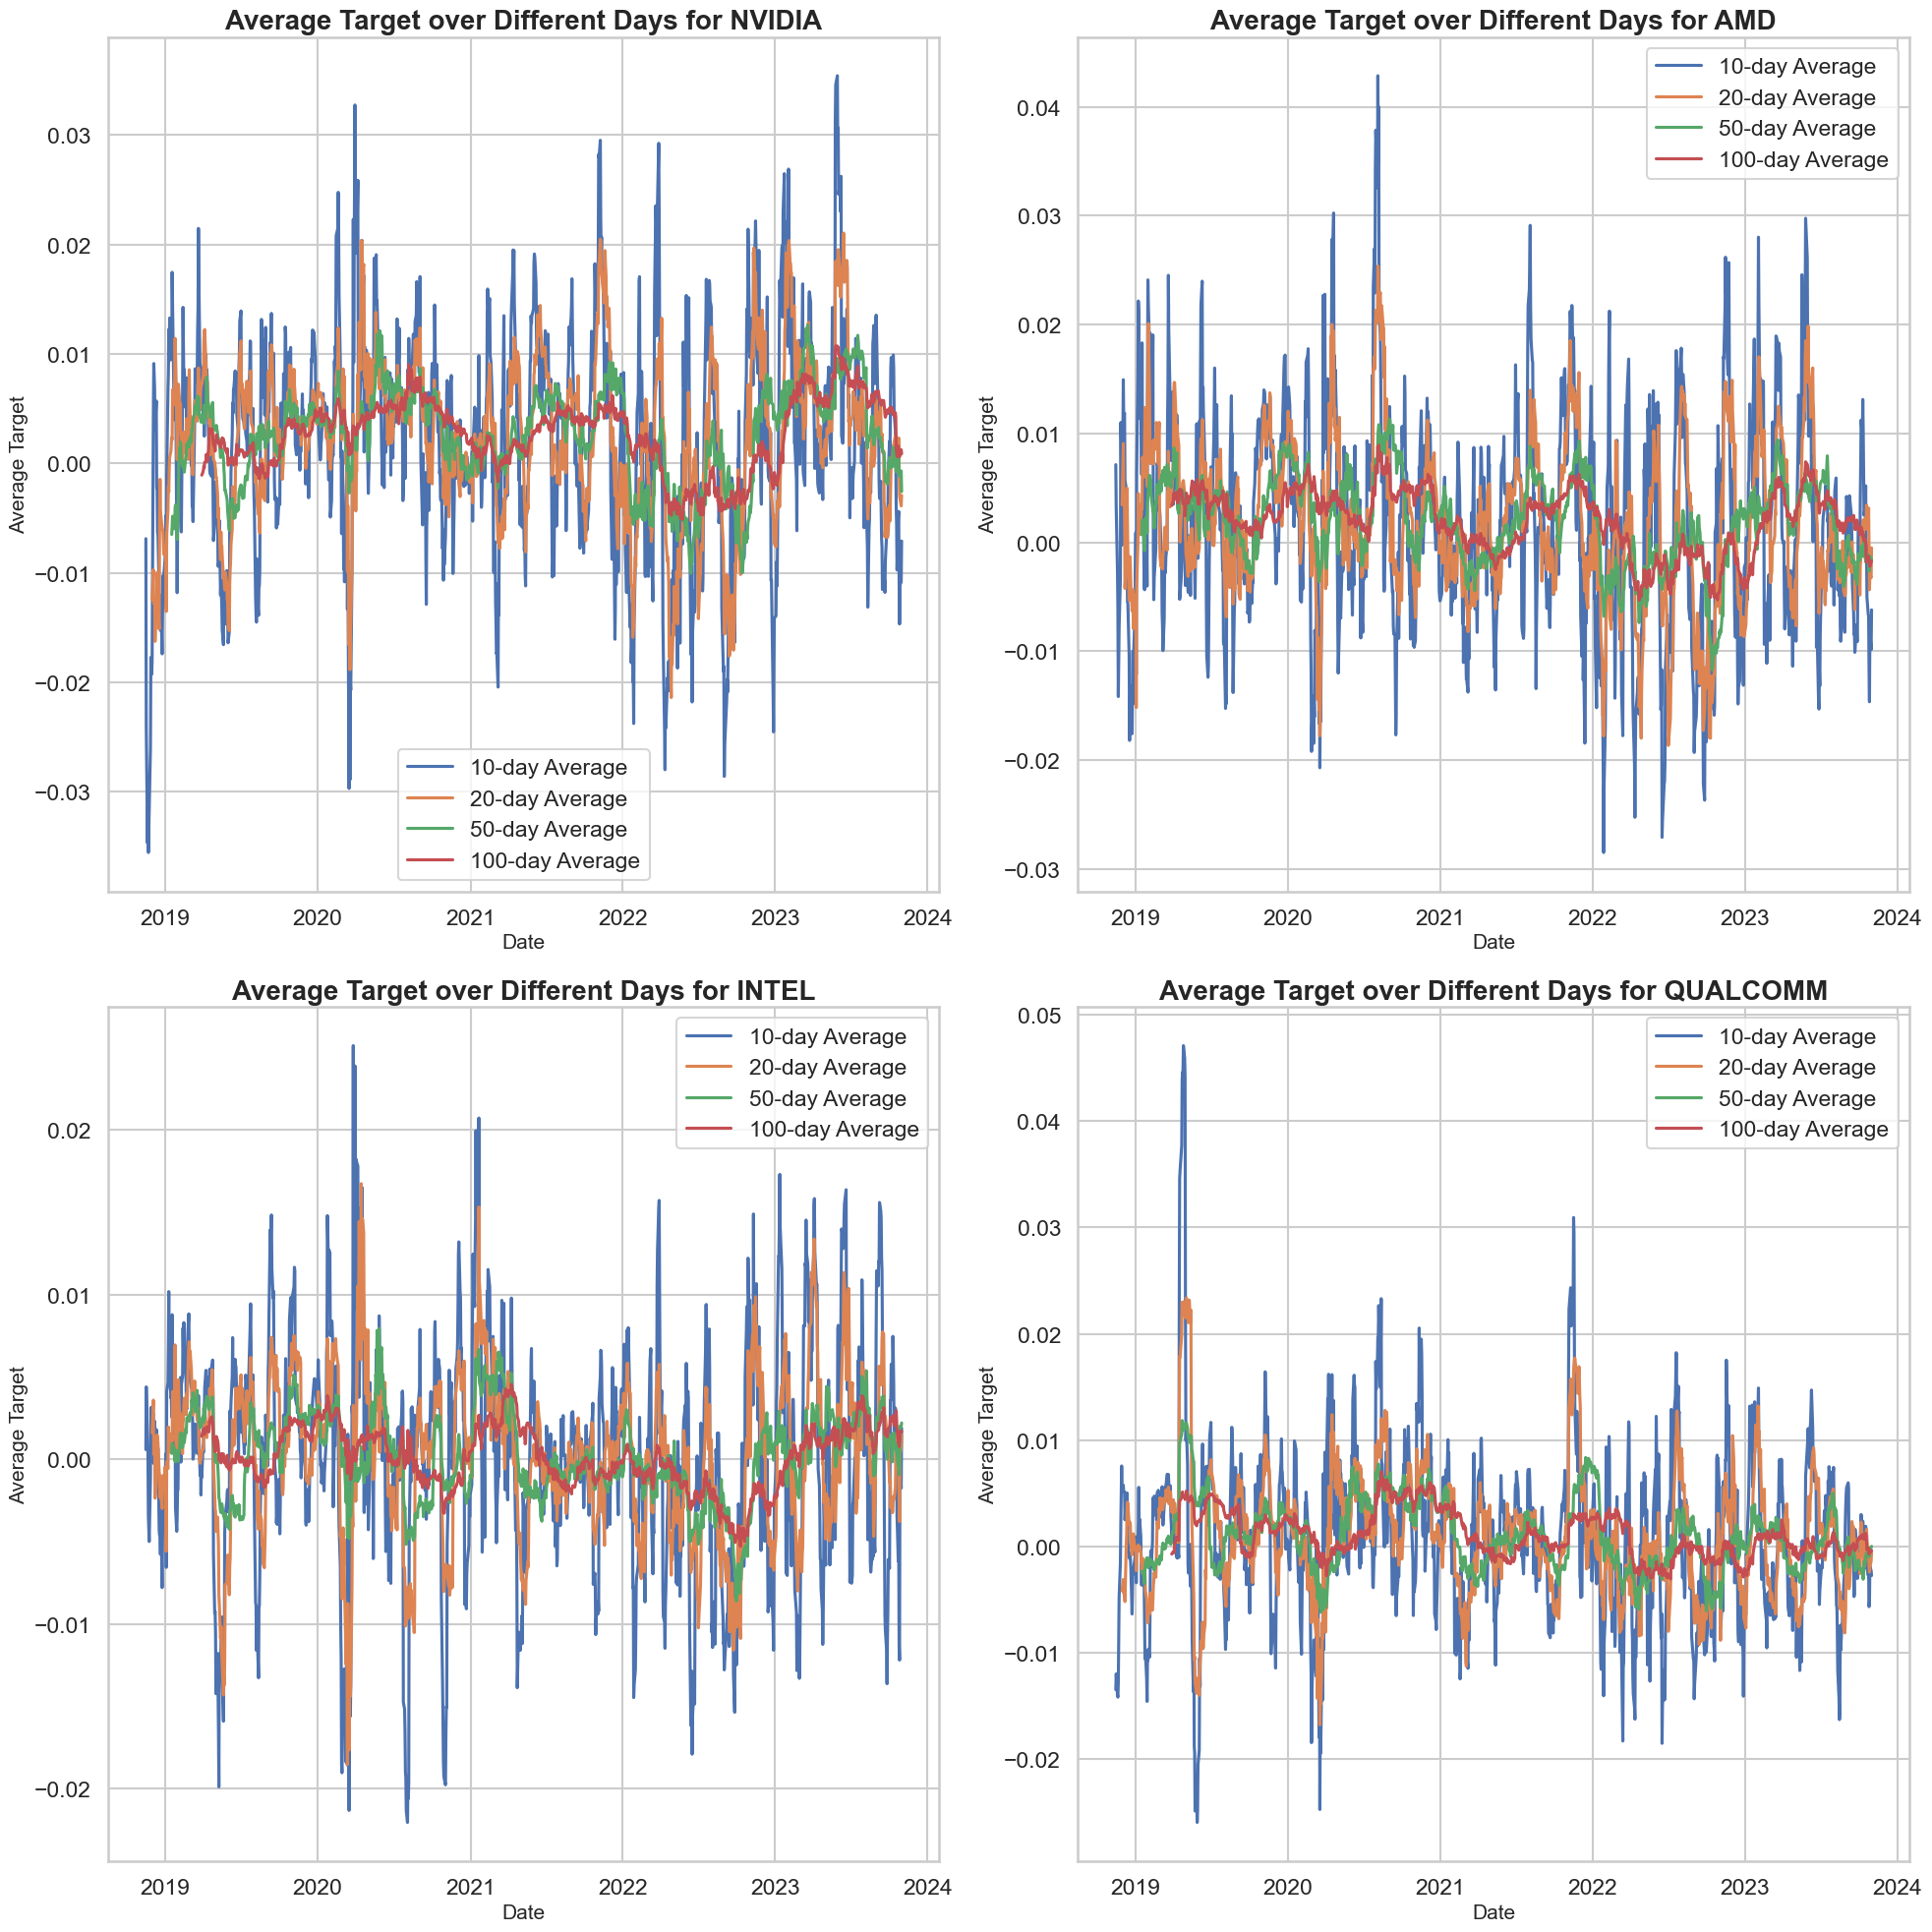

In [37]:
# Create a new figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Define rolling windows for calculating the average target
rolling_windows = [10, 20, 50, 100]

# Loop through each stock in your list and plot its average target over different days
for i, (stock_data, stock_name) in enumerate(zip(data_list, c_names)):
    # Calculate the target variable (e.g., daily returns) for the current stock
    daily_return = stock_data['Adj Close'].pct_change()
    
    # Plot the average target over different days
    row, col = divmod(i, 2)  # Calculate the row and column indices of the subplot
    for window in rolling_windows:
        # Calculate the average target using a rolling window
        avg_target = daily_return.rolling(window).mean()
        
        # Plot the average target on the appropriate subplot
        axs[row, col].plot(avg_target, label=f'{window}-day Average')
        axs[row, col].set_title(f'Average Target over Different Days for {stock_name}', weight='bold', fontsize=20)
        axs[row, col].set_xlabel('Date', fontsize=15)
        axs[row, col].set_ylabel('Average Target', fontsize=15)
        axs[row, col].legend()

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


### Predictive Analysis
